<div style='background-image: url("../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Syngine</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Green's Functions for Moment Tensor Inversions</div>
        </div>
    </div>
</div>

Seismo-Live: http://seismo-live.org

##### Authors:
* Lion Krischer ([@krischer](https://github.com/krischer))

---

This is a tutorial teaching how to use Syngine's Green's function to reconstruct seismograms from arbitrary source mechanisms.

* [IRIS Syngine Service](http://ds.iris.edu/ds/products/syngine/)

In [1]:
# First a bit of setup to make the plots appear in the
# notebook and make them look a bit nicer.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [2]:
import obspy
import numpy as np

In [3]:
# This is a helper function to return a ZRT stream for a certain
# moment tensor.

def seismograms_for_mt(st, az, m_rr, m_tt, m_pp, m_rt, m_rp, m_tp):
    # Convert to radian.
    az = np.deg2rad(az)
    # shortcuts to the data.
    TSS = st.select(channel="TSS")[0].data
    ZSS = st.select(channel="ZSS")[0].data
    RSS = st.select(channel="RSS")[0].data
    TDS = st.select(channel="TDS")[0].data
    ZDS = st.select(channel="ZDS")[0].data
    RDS = st.select(channel="RDS")[0].data
    ZDD = st.select(channel="ZDD")[0].data
    RDD = st.select(channel="RDD")[0].data
    ZEP = st.select(channel="ZEP")[0].data
    REP = st.select(channel="REP")[0].data
    
    # Apply formula from Minson and Dreger, 2008.
    Z = m_tt * (ZSS / 2 * np.cos(2 * az) - ZDD / 6 + ZEP / 3) + \
        m_pp * (-ZSS / 2 * np.cos(2 * az) - ZDD / 6 + ZEP / 3) + \
        m_rr * (ZDD / 3 + ZEP / 3) + \
        m_tp * (ZSS * np.sin(2 * az)) + \
        m_rt * (ZDS * np.cos(az)) + \
        m_rp * (ZDS * np.sin(az))
        
    R = m_tt * (RSS / 2 * np.cos(2 * az) - RDD / 6 + REP / 3) + \
        m_pp * (-RSS / 2 * np.cos(2 * az) - RDD / 6 + REP / 3) + \
        m_rr * (RDD / 3 + REP / 3) + \
        m_tp * (RSS * np.sin(2 * az)) + \
        m_rt * (RDS * np.cos(az)) + \
        m_rp * (RDS * np.sin(az))
        
    T = m_tt * (TSS / 2 * np.sin(2 * az)) - \
        m_pp * (TSS / 2 * np.sin(2 * az)) - \
        m_tp * (TSS * np.cos(2 * az)) + \
        m_rt * (TDS * np.sin(az)) - \
        m_rp * (TDS * np.cos(az))
        
    tr_z = obspy.Trace(data=Z, header=st[0].stats)
    tr_z.stats.channel = "EHZ"
    tr_r = obspy.Trace(data=R, header=st[0].stats)
    tr_r.stats.channel = "EHR"
    tr_t = obspy.Trace(data=T, header=st[0].stats)
    tr_t.stats.channel = "EHT"
    
    return obspy.Stream(traces=[tr_z, tr_r, tr_t])

In [4]:
import obspy
import requests

# Base URL and model choice.
BASE_URL = "http://service.iris.edu/irisws/syngine/1/query?format=miniseed&model=ak135f_5s&"

# Get components for a distance of 10 degrees and a source depth of 1 km.
GREENS_URL = BASE_URL + \
    "greensfunction=1&sourcedistanceindegrees=10&sourcedepthinmeters=1000"

# Request the elementary seismograms.
st = obspy.read(GREENS_URL)

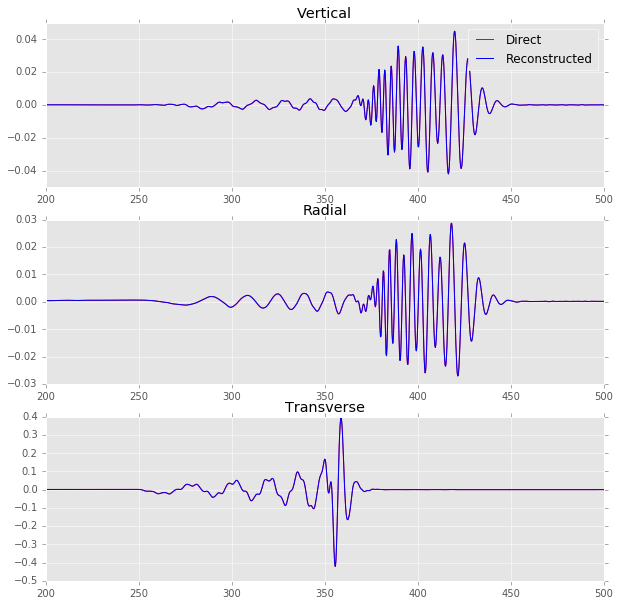

In [5]:
# Example for a certain moment tensor.
m_rr, m_tt, m_pp, m_rt, m_rp, m_tp = 1E20, -2E20, 0.4E20, -0.7E20, 1.3E20, -2E20

# A: Get it directly from Syngine.
MT_URL = BASE_URL + (
    "sourcelatitude=0&sourcelongitude=10&sourcedepthinmeters=1000&"
    "sourcemomenttensor=%g,%g,%g,%g,%g,%g&"
    "receiverlatitude=0&receiverlongitude=0&"
    "components=ZRT"% (m_rr, m_tt, m_pp, m_rt, m_rp, m_tp))
st_mt = obspy.read(MT_URL.replace("+", ""))

# B: Get it via Green's function arithmetics.
st_g = seismograms_for_mt(st, az=-90.0, m_rr=m_rr, m_tt=m_tt, m_pp=m_pp,
                          m_rt=m_rt, m_rp=m_rp, m_tp=m_tp)

# Compare everything.
plt.figure(figsize=(10, 10))

plt.subplot(311)
plt.title("Vertical")
tr_mt = st_mt.select(component="Z")[0]
tr_g = st_g.select(component="Z")[0]
plt.plot(tr_mt.times(), tr_mt.data, color="red", label="Direct")
plt.plot(tr_g.times(), tr_g.data, color="blue", label="Reconstructed")
plt.legend()
plt.xlim(200, 500)

plt.subplot(312)
plt.title("Radial")
tr_mt = st_mt.select(component="R")[0]
tr_g = st_g.select(component="R")[0]
plt.plot(tr_mt.times(), tr_mt.data, color="red")
plt.plot(tr_g.times(), tr_g.data, color="blue")
plt.xlim(200, 500)

plt.subplot(313)
plt.title("Transverse")
tr_mt = st_mt.select(component="T")[0]
tr_g = st_g.select(component="T")[0]
plt.plot(tr_mt.times(), tr_mt.data, color="red")
plt.plot(tr_g.times(), tr_g.data, color="blue")
plt.xlim(200, 500)

plt.show()

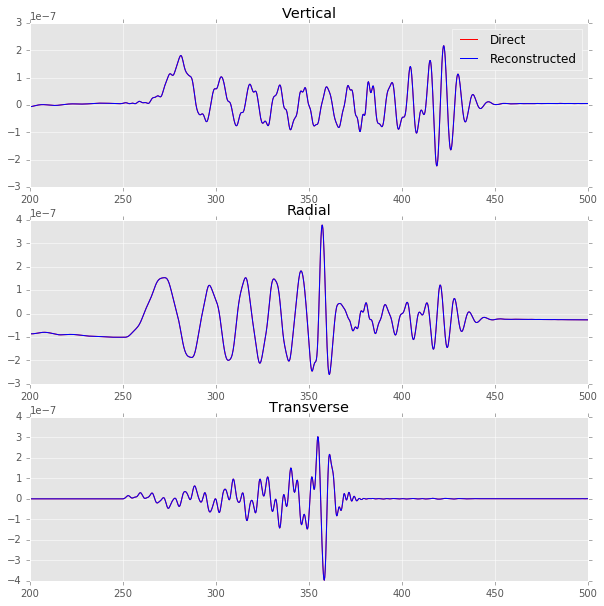

In [6]:
# Some thing again but for a different tensor.
m_rr, m_tt, m_pp, m_rt, m_rp, m_tp = 2E15, .4E17, -0.4E14, 2.7E15, -1.3E13, 1.3E14

# A: Get it directly from Syngine.
MT_URL = BASE_URL + (
    "sourcelatitude=0&sourcelongitude=10&sourcedepthinmeters=1000&"
    "sourcemomenttensor=%g,%g,%g,%g,%g,%g&"
    "receiverlatitude=0&receiverlongitude=0&"
    "components=ZRT"% (m_rr, m_tt, m_pp, m_rt, m_rp, m_tp))
st_mt = obspy.read(MT_URL.replace("+", ""))

# B: Get it via Green's function arithmetics.
st_g = seismograms_for_mt(st, az=-90.0, m_rr=m_rr, m_tt=m_tt, m_pp=m_pp,
                          m_rt=m_rt, m_rp=m_rp, m_tp=m_tp)

# Compare everything.
plt.figure(figsize=(10, 10))

plt.subplot(311)
plt.title("Vertical")
tr_mt = st_mt.select(component="Z")[0]
tr_g = st_g.select(component="Z")[0]
plt.plot(tr_mt.times(), tr_mt.data, color="red", label="Direct")
plt.plot(tr_g.times(), tr_g.data, color="blue", label="Reconstructed")
plt.legend()
plt.xlim(200, 500)

plt.subplot(312)
plt.title("Radial")
tr_mt = st_mt.select(component="R")[0]
tr_g = st_g.select(component="R")[0]
plt.plot(tr_mt.times(), tr_mt.data, color="red")
plt.plot(tr_g.times(), tr_g.data, color="blue")
plt.xlim(200, 500)

plt.subplot(313)
plt.title("Transverse")
tr_mt = st_mt.select(component="T")[0]
tr_g = st_g.select(component="T")[0]
plt.plot(tr_mt.times(), tr_mt.data, color="red")
plt.plot(tr_g.times(), tr_g.data, color="blue")
plt.xlim(200, 500)

plt.show()